In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch
torch.manual_seed(0)
class CustomDataset(Dataset):
    def __init__(self, csv_file, label_encoders):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[:].dropna()
        self.text = self.data['review'].tolist()
        self.target1 = self.data['drug'].tolist()
        self.target2 = self.data['condition'].tolist()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Retrieve label encoders from the provided dictionary
        self.label_encoder1 = label_encoders['target1']
        self.label_encoder2 = label_encoders['target2']

        # Encode target variables using the retrieved label encoders
        self.target1_encoded = self.label_encoder1.transform(self.target1)
        self.target2_encoded = self.label_encoder2.transform(self.target2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text[idx]
        target1 = self.target1_encoded[idx]
        target2 = self.target2_encoded[idx]

        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'target1': target1,
            'target2': target2,
            'original_target1': self.target1[idx],
            'original_target2': self.target2[idx]
        }

# Example usage:
csv_file_train = r'D:\Downloads\df_train_20.csv'  # Replace 'your_data.csv' with the path to your CSV file
csv_file_test = r"D:\Downloads\df_test_20_final.csv"
# csv_file = r'D:\Downloads\fdf.csv'  # Replace 'your_data.csv' with the path to your CSV file

# Create label encoders for target variables
label_encoders = {}
label_encoders['target1'] = LabelEncoder()
label_encoders['target2'] = LabelEncoder()

# Fit label encoders on target variables
# data = pd.read_csv(csv_file_test)
data_train = pd.read_csv(csv_file_train)
label_encoders['target1'].fit(data_train['drug'])
label_encoders['target2'].fit(data_train['condition'])

# Create dataset with label encoders
dataset = CustomDataset(csv_file_test, label_encoders)


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [3]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes1)
        # self.fc2 = nn.Linear(self.bert.config.hidden_size, num_classes2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        # Use pooled_output for final classification
        logits1 = self.fc1(pooled_output)
        # logits2 = self.fc2(pooled_output)

        return logits1

# Example usage:
num_classes1 = len(label_encoders['target1'].classes_)
num_classes2 = len(label_encoders['target2'].classes_)
model = BertClassifier(num_classes2,num_classes1, )


In [4]:
# import torch
# # Load the saved model state dictionary
model_path = r"D:\Downloads\model_solo2_20.pth"
model.load_state_dict(torch.load(model_path))
print("Model loaded successfully!")

Model loaded successfully!


In [8]:
from tqdm import tqdm

def inference(model, dataloader, label_encoders, device):
    model = model.to(device)
    model.eval()
    all_preds1 = []
    all_preds2 = []
    all_targets1 = []
    all_targets2 = []

    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target1 = batch['target2'].to(device)
        # target2 = batch['target2'].to(device)

        logits1 = model(input_ids, attention_mask)

        all_preds1.extend(logits1.argmax(dim=1).cpu().numpy())
        # all_preds2.extend(logits2.argmax(dim=1).cpu().numpy())
        all_targets1.extend(target1.cpu().numpy())
        # all_targets2.extend(target2.cpu().numpy())

    # Reverse label encoding
    label_encoder1 = label_encoders['target2']
    # label_encoder2 = label_encoders['target2']
    original_preds1 = label_encoder1.inverse_transform(all_preds1)
    # original_preds2 = label_encoder2.inverse_transform(all_preds2)
    original_targets1 = label_encoder1.inverse_transform(all_targets1)
    # original_targets2 = label_encoder2.inverse_transform(all_targets2)

    return original_preds1, original_targets1


# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds1, targets1 = inference(model, test_dataloader, label_encoders, device)

# Analysis of predictions
for pred1, target1 in zip(preds1, targets1, ):
    print(f'Predicted target1: {pred1}, Original target1: {target1}')
    # print(f'Predicted target2: {pred2}, Original target2: {target2}')
    print()  # Add a newline for readability


  0%|          | 0/11558 [00:00<?, ?it/s]

100%|██████████| 11558/11558 [19:24<00:00,  9.93it/s]


Predicted target1: Birth Control, Original target1: Depression

Predicted target1: Birth Control, Original target1: Urinary Tract Infection

Predicted target1: Birth Control, Original target1: Birth Control

Predicted target1: Birth Control, Original target1: Birth Control

Predicted target1: Birth Control, Original target1: Vaginal Yeast Infection

Predicted target1: Birth Control, Original target1: Insomnia

Predicted target1: Birth Control, Original target1: Urinary Tract Infection

Predicted target1: Birth Control, Original target1: Insomnia

Predicted target1: Birth Control, Original target1: Irritable Bowel Syndrome

Predicted target1: Birth Control, Original target1: Diabetes, Type 2

Predicted target1: Birth Control, Original target1: Birth Control

Predicted target1: Birth Control, Original target1: Depression

Predicted target1: Birth Control, Original target1: Birth Control

Predicted target1: Birth Control, Original target1: Birth Control

Predicted target1: Birth Control, 

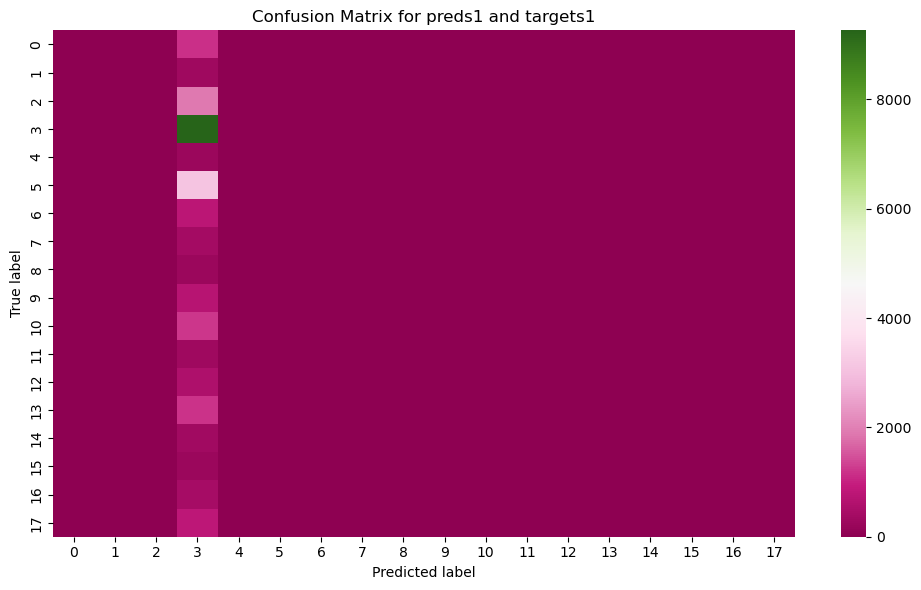

For preds1 and targets1:
Accuracy: 0.40067485724173735
F1 Score: 0.03178427052662645
Confusion Matrix:
 [[   0    0    0 1124    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  307    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 1905    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 9262    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  239    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 3084    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  794    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  381    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  231    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  714    0    0    0    0

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming preds1, preds2, targets1, and targets2 are your prediction and target arrays/lists

# Calculate accuracy

# Calculate accuracy
accuracy_1 = accuracy_score(targets1, preds1)
# accuracy_2 = accuracy_score(targets2, preds2)

# Calculate F1 score
f1_score_1 = f1_score(targets1, preds1,average="macro")


# Calculate confusion matrix
conf_matrix_1 = confusion_matrix(targets1, preds1)


plt.figure(figsize=(10, 6))

plt.subplot(1, 1, 1)
sns.heatmap(conf_matrix_1, fmt='d', cmap='PiYG')
plt.title("Confusion Matrix for preds1 and targets1")
plt.xlabel("Predicted label")
plt.ylabel("True label")


plt.tight_layout()
plt.show()

print("For preds1 and targets1:")
print("Accuracy:", accuracy_1)
print("F1 Score:", f1_score_1)
print("Confusion Matrix:\n", conf_matrix_1)


print("For preds1 and targets1:")
print("Accuracy:", accuracy_1)
print("F1 Score:", f1_score_1)
print("Confusion Matrix:\n", conf_matrix_1)
